In [ ]:
%%capture
!pip install --upgrade d2l==1.0.0a0
import os
import pandas as pd
import torch
import numpy as np
from torch.utils import data
from d2l import torch as d2l

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

import pandas as pd

ratings = pd.read_csv("ml-100k/u.data", sep="\t", header=None,
                      names=["user_id", "item_id", "rating", "timestamp"])

ratings.head()


--2025-09-05 19:18:57--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.grouplens.org/datasets/movielens/ml-100k.zip [following]
--2025-09-05 19:18:58--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  2.86MB/s    in 1.6s    

2025-09-05 19:19:01 (2.86 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
import pandas as pd

def read_data_100k():
    data = pd.read_csv("ml-100k/u.data", sep = "\t", header = None,
                      names = ["user_id", "item_id", "rating", "timestamp"])
    num_users = len(data.user_id.unique())
    num_items = len(data.item_id.unique())
    return data, num_users, num_items

In [ ]:
data, num_users, num_items = read_data_100k()
sparsity = 1- len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))
print(sorted(data.user_id.unique()))

number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.i

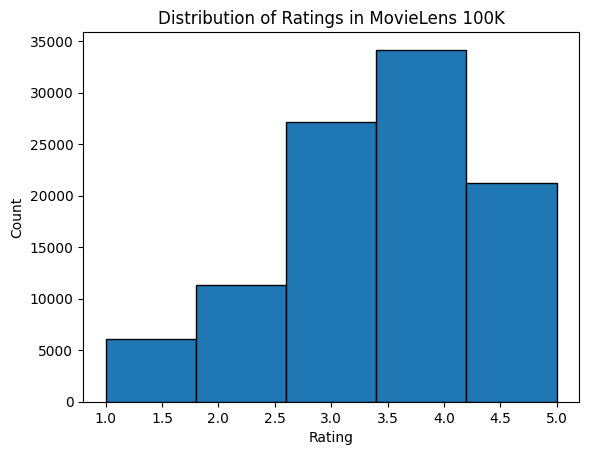

In [ ]:
import matplotlib.pyplot as plt

plt.hist(data['rating'], bins=5, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()

In [ ]:
# create a sequence aware split mode: input the latest rating for each user into the testing set, everything
# else chuck into the train set
# create a random mode. mask out a percentage equivalent to the test_ratio
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
  if split_mode == 'seq-aware':
    train_list, train_items, test_items = [], {}, {}
    for line in data.itertuples():
      user, id, rating, time = line[1], line[2], line[3], line[4]
      train_items.setdefault(user, []).append((user, id, rating, time))
      if user not in test_items or test_items[user][-1] < time:
        test_items[user] = (id, rating, time)
    for u in range(1, num_users + 1):
      train_list.extend(sorted(train_items[u], key = lambda k: k[3]))
    test_data = [(key, *value) for key, value in test_items.items()]
    train_data = [item for item in train_list if item not in test_data]
    test_data = pd.DataFrame(test_data)
    train_data = pd.DataFrame(train_data)
  else:
    mask = np.random.uniform(0, 1, len(data)) < test_ratio
    test_data = data[mask]
    train_data = data[~mask]
  return train_data, test_data

In [ ]:
test_data, train_data = split_data_ml100k(data, num_users,num_items)
test_data.shape, train_data.shape
# train_items.shape, test_items.shape,

((90092, 4), (9908, 4))

In [ ]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_100k()

    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)

    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)

    train_set = TensorDataset(
        torch.tensor(train_u),
        torch.tensor(train_i),
        torch.tensor(train_r, dtype = torch.float32))

    test_set = TensorDataset(
        torch.tensor(test_u),
        torch.tensor(test_i),
        torch.tensor(test_r, dtype = torch.float32))

    train_iter = DataLoader(
        train_set, shuffle=True, drop_last = False,
        batch_size=batch_size)

    test_iter = DataLoader(
        test_set, batch_size=batch_size)

    return num_users, num_items, train_iter, test_iter

In [ ]:
from torch import nn

class MF(nn.Module):
  def __init__(self, num_factors, num_users, num_items, **kwargs):
    super().__init__()
    self.P = nn.Embedding(num_embeddings = num_users, embedding_dim = num_factors)
    self.Q = nn.Embedding(num_embeddings = num_items, embedding_dim = num_factors)
    self.user_bias = nn.Embedding(num_users, 1)
    self.item_bias = nn.Embedding(num_items, 1)

  def forward(self, user_id, item_id):
    pi = self.P(user_id)
    qi = self.Q(item_id)
    p_b = self.user_bias(user_id)
    q_b = self.item_bias(item_id)
    return (pi * qi).sum(dim=1) + p_b.view(-1) + q_b.view(-1)

  #axis might be a problem

In [ ]:
import torch.nn.functional as F

def rmse(predicted, real):
  mse = F.mse_loss(predicted, real, reduction = 'mean')
  return torch.sqrt(mse)

In [ ]:
def evaluator(net, test_iter, devices):
  rmse_list = []
  # idk if this works LOL
  for user, item, rating in test_iter:
    user = user.to(devices)
    item = item.to(devices)
    rating = rating.to(devices)
    y_hat = net(user,item)
    rmse_list.append(rmse(y_hat, rating).item())
  return float(sum(rmse_list) / len(rmse_list))


In [ ]:
def train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices=d2l.try_all_gpus(), evaluator=None,
                        **kwargs):
    timer = d2l.Timer()

    train_losses = []
    test_rmses = []

    for epoch in range(num_epochs):
        total_loss = 0.
        for i, (user, item, rating) in enumerate(train_iter):
            timer.start()
            user, item, rating = user.to(devices), item.to(devices), rating.to(devices)
            pred = net(user, item)
            # print(f'Rating device: {rating.device} | Pred device: {pred.device}')
            # break
            l = loss(pred, rating)

            trainer.zero_grad()
            l.backward()
            trainer.step()

            total_loss += l.item()

            timer.stop()

        if len(kwargs) > 0:
            test_rmse = evaluator(net, test_iter, kwargs['inter_mat'], devices)
        else:
            test_rmse = evaluator(net, test_iter, devices)

        ave_loss = total_loss / (i + 1)

        train_losses.append(ave_loss)
        test_rmses.append(test_rmse)

        print(f'Ave Loss: {ave_loss}, Test RMSE: {test_rmse}') # Added print for clarity

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_rmses, label='Test RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('Training and Test Metrics over Epochs')
    plt.legend()
    plt.show()

TEST_ITER_SHAPE: 943
TRAIN_ITER_SHAPE: 99057
Ave Loss: 9.296970650092844, Test RMSE: 1.9526947140693665
Ave Loss: 1.4139322896593625, Test RMSE: 1.219120740890503
Ave Loss: 0.9696767904709295, Test RMSE: 1.1011298894882202
Ave Loss: 0.9054873435153175, Test RMSE: 1.079566478729248
Ave Loss: 0.8850461155483403, Test RMSE: 1.0680081844329834
Ave Loss: 0.8753629806115455, Test RMSE: 1.0645606517791748
Ave Loss: 0.8672095712312718, Test RMSE: 1.061860740184784
Ave Loss: 0.8597400753768449, Test RMSE: 1.0596909523010254
Ave Loss: 0.8500189427862462, Test RMSE: 1.0570447444915771
Ave Loss: 0.8385258249400818, Test RMSE: 1.0560293793678284
Ave Loss: 0.8255868492667208, Test RMSE: 1.0560014843940735
Ave Loss: 0.8117636678759584, Test RMSE: 1.0536888241767883
Ave Loss: 0.7960556143337918, Test RMSE: 1.0569417476654053
Ave Loss: 0.7794900023445641, Test RMSE: 1.0488315224647522
Ave Loss: 0.7628844945701128, Test RMSE: 1.0435813665390015
Ave Loss: 0.745538487569573, Test RMSE: 1.0492199659347534


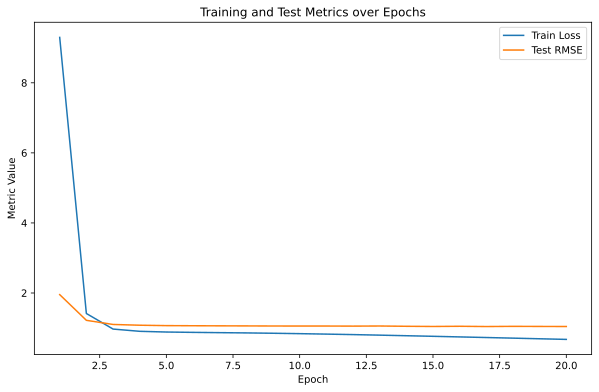

In [ ]:
import torch.optim as optim

devices = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_users, num_items, train_iter, test_iter = split_and_load_ml100k(
    test_ratio=0.1, batch_size=512)
print(f"TEST_ITER_SHAPE: {len(test_iter.dataset)}")
print(f"TRAIN_ITER_SHAPE: {len(train_iter.dataset)}")
net = MF(30, num_users, num_items)
net.to(devices)

for param in net.parameters():
  torch.nn.init.normal_(param, mean = 0.0, std = 0.01)

loss = torch.nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.002, weight_decay=1e-5)

num_epochs = 20
train_recsys_rating(net, train_iter, test_iter, loss, optimizer,
                    num_epochs, devices=devices, evaluator=evaluator)



